# Random Forest Estimate in High Dimensions
In this notebook, we will study convergence rates when the dimension of our data grows. To do so, we will be sampling data in increasing dimensions. The data will be similar to the case in the notebook Simple Converge Tests except instead of univariate normal we will use multivariate. The covariance matrix will be the identity matrix for now. Thus we describe our study as follows:

Let $(\boldsymbol{X_i}, Y_i)$ be drawn such that $Y \sim Bernoulli(1/2)$ ($Y$ = -1 or 1) and $\boldsymbol X \sim \mathcal{N_d}(y\mu_1, \dots, y\mu_d, \boldsymbol I)$  

To further simplifiy the problem, we will have one mean equal mu and the rest be 0.

## Sampling code

In [1]:
import numpy as np

def get_multivariate_sample(n, d, mean):
    x_sample = []
    y_sample = []
    means = np.zeros(d)
    means[0] = mean
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.multivariate_normal(-means, np.identity(d))
        else:
            x = np.random.multivariate_normal(means, np.identity(d))
        x_sample.append(x.tolist())
        y_sample.append(y)
    return x_sample, y_sample

Let's validate that this sampling code is working by visualizing it with d = 2:

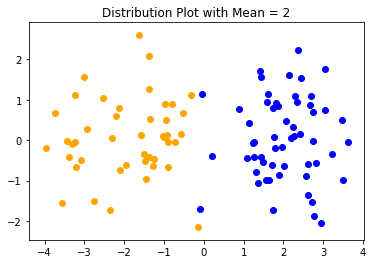

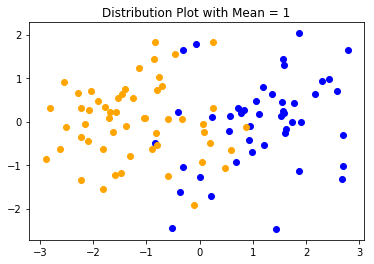

In [3]:
import matplotlib.pyplot as plt

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_multivariate_sample(100, 2, 2)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 2")
plt.show()

X, y = get_multivariate_sample(100, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 1")
plt.show()


Ok, our sampling code is working. Now let's do a quick convergence test as n-> infinity when d = 1 and d = 2 and try see if the rates are different.

## Original Algorithm Code

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import entropy

def estimate_conditional_entropy(X, y, n_trees = 10, max_depth = None, bootstrap = False):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = max_depth, random_state = 0)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.6915274684369157


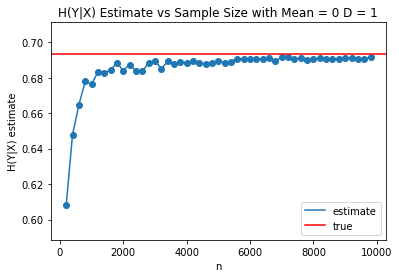

In [5]:
np.warnings.filterwarnings('ignore')

def get_cond_entropy_vs_n(mean, d):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(estimate_conditional_entropy(np.array(X), y, 200, int(np.log(d) + 3), bootstrap = False))
    return sample_sizes, conditional_entropy


sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, 1)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0 D = 1")
plt.show()

0.6929904389738972


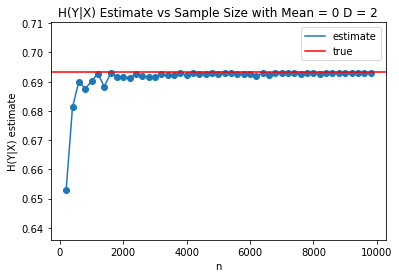

In [7]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, 10)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0 D = 2")
plt.show()

0.6930195592353486


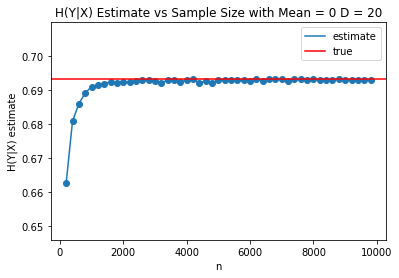

In [9]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, 20)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0 D = 20")
plt.show()

0.6930508496425877


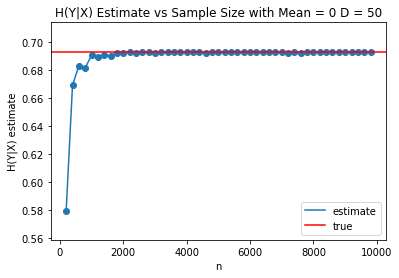

In [10]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, 50)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0 D = 50")
plt.show()

In [11]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(0, 100)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0 D = 50")
plt.show()

KeyboardInterrupt: 

Ok what about a different mean?

0.3529485077273062


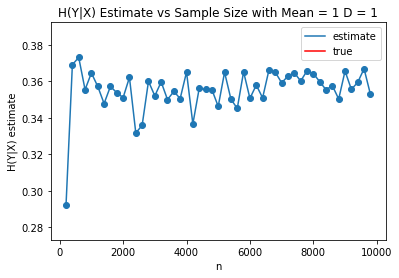

In [20]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, 1)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
#line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
#plt.yticks(np.arange(.48, .7, 0.02))
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1 D = 1")
plt.show()

0.5502786770238243


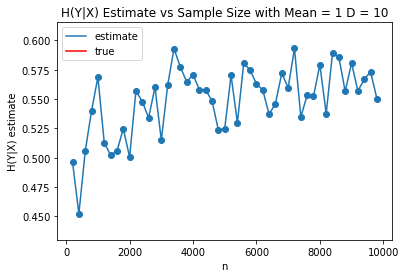

In [22]:
#sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, 10)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
#line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1 D = 10")
plt.show()

0.6035852790697286


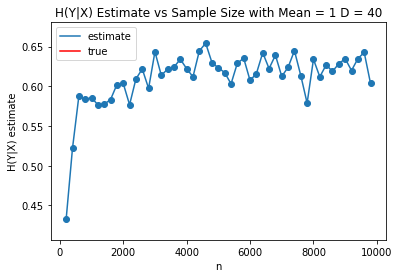

In [23]:
sample_sizes, cond_entropy = get_cond_entropy_vs_n(1, 40)
print(cond_entropy[-1])
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1 D = 40")
plt.show()